## Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [68]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()


In [20]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
#Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:] = 0.03/12

In [21]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

### Steps to CCPI
1. Cushion - (Asset Value minus Floor Value)
2. Compute an Allocation to Safe and Risky Assets --> m * risk_budget
3. Recompute the Asset Value based on the returns



In [31]:
def compound1(r): 
    return (1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum()) #expm1 --> exponential minus 1

In [24]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [25]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [29]:
%timeit compound1(risky_r)

605 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
%timeit compound2(risky_r) #More efficient with compound 2

465 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [38]:
### Back to CCPI
from datetime import date


dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)


for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1) 
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    ## update the account value for this time step
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1+safe_r.iloc[step])
    
    # save the values so I can look at the history and plot it etc
    cushion_history.iloc[step]= cushion
    risky_w_history.iloc[step]=risky_w
    account_history.iloc[step]=account_value





<AxesSubplot:>

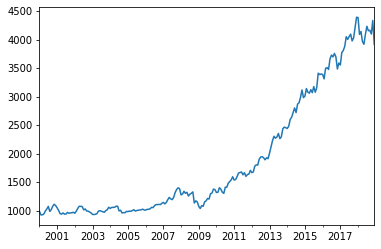

In [46]:
risky_wealth = (start *(1+risky_r).cumprod())

account_history["Beer"].plot()


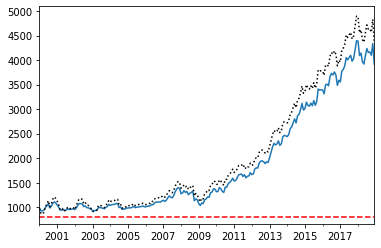

In [50]:
ax = account_history["Beer"].plot()

risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

<AxesSubplot:>

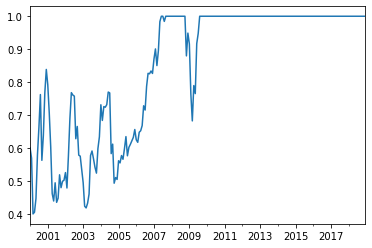

In [52]:
risky_w_history["Beer"].plot()

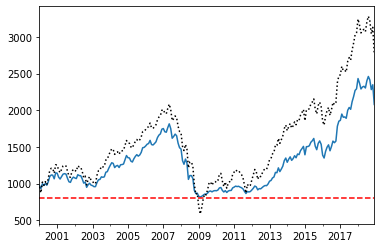

In [53]:
ind = "Fin"
ax = account_history[ind].plot()

risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

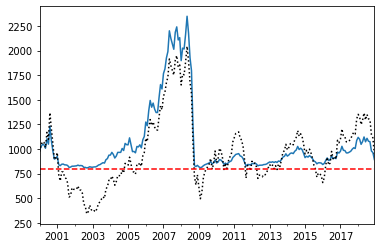

In [54]:
ind = "Steel"
ax = account_history[ind].plot()

risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

In [57]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.006139,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,-0.000094,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,-0.001866,0.354314,-0.271368


In [62]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.006710,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.000420,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,-0.001118,0.383772,-0.259582


<AxesSubplot:>

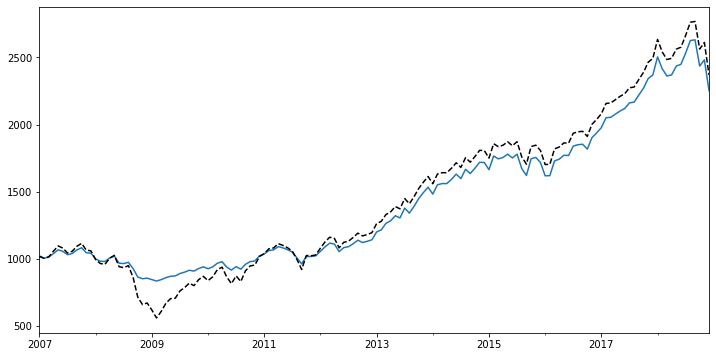

In [63]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize = (12, 6), legend = False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend= False)

In [64]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,-0.004205,0.280618,-0.499943


In [65]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,-0.003188,0.382052,-0.229683


In [70]:
# Drawdown constraints

btr =erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown = 0.25)


<AxesSubplot:>

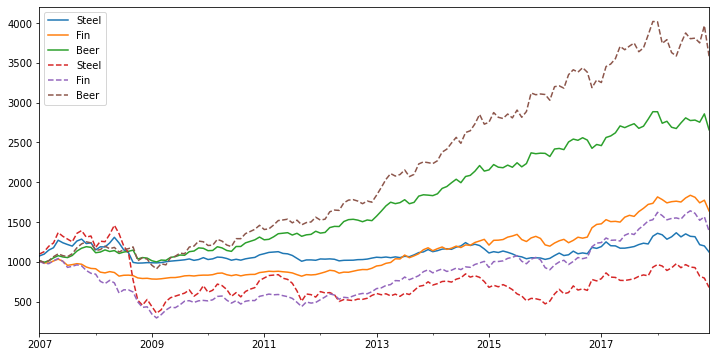

In [71]:
ax = btr["Wealth"].plot(figsize=(12, 6))
btr["Risky Wealth"].plot(ax =ax, style = "--")

In [73]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.009735,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,-0.000156,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,-0.000083,0.620132,-0.271368


In [74]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.002480,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,-0.000943,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.000545,0.613413,-0.161186
